# Mapping human lymph node cell types to 10X Visium - estimating reference expression signatures

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YosefLab/scvi-tools/blob/37af9b2a43667c1bfb64d55f51b4a245f5738be6/scvi/external/cell2location/tutorial/cell2location_analysis_2_estimating_signatures.ipynb)

Cell2location maps cell types by integrating single cell/nucleus and spatial transcriptomics data. This is achieved by estimating which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, taking technical effects into account (platform/technology effect, contaminating RNA, unexplained variance).

Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f={1, .., F}$, can be estimated from sc/snRNA-seq data using 2 provided methods (see below). Cell2location needs untransformed unnormalised spatial mRNA counts as input. You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see paper methods for more guidance).

We provide 2 methods for estimating reference expression signatures of cell types from scRNA-seq data:

1) a statistical method based on Negative Binomial regression. We generally recommend using NB regression, which allows to robustly combine data across technologies and batches, which results in improved spatial mapping accuracy. This notebook shows use a dataset composed on multiple batches and technologies to estimate that. 

2) hard-coded computation of per-cluster average mRNA counts for individual genes (`scvi.external.cell2location.compute_cluster_averages`). When the batch effects are small, this faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.


### Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load refence cell type expression signatures](#Loading_signatures)
* [Run scvi-cell2location](#cell2location)
* [Leiden clustering of cell abundance](#region_clustering)




### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output.

In [2]:
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/regression_model/'

scvi_run_name = f'{results_folder}signatures_v3_Adam_lr0002_alpha20_pyro_ref/'
scvi_ref_run_name = f'{sc_results_folder}signatures_v0_Adam_lr0002_ref/'

sc.settings.figdir = f'{scvi_run_name}/plots/'

# adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
# adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

### Load reference cell type expression signatures <a class="anchor" id="Loading_signatures"></a>

The signatures were estimated from scRNA-seq data, accounting for batch effect, using a separate model, as shown here: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_estimating_signatures.html

Here we download the h5ad object with results:

In [3]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_ref/", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.index = adata_snrna_raw.var['SYMBOL']

inf_aver.index = anndata.utils.make_index_unique(inf_aver.index.astype(str), '-')

inf_aver.iloc[0:5, 0:5]

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO
SYMBOL,,,,,
Xkr4,0.040710,0.079320,0.057454,0.059812,0.084526
Gm1992,0.004963,0.006407,0.009193,0.007305,0.016441
Mrpl15,0.112017,0.054752,0.094273,0.067388,0.081231
Tcea1,0.093426,0.106448,0.136787,0.096871,0.091096
Rgs20,3.554433,4.124567,4.123194,3.952404,1.159038


## Train scvi-cell2location <a class="anchor" id="scvi-cell2location"></a>

In [4]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/stickels_et_al_2020_slide_seqV2/'

slideseq = anndata.read_h5ad(f'{sp_data_folder}stickels_et_al_2020_slide_seqV2.h5ad')

slideseq.var['SYMBOL'] = slideseq.var_names
# slideseq.var_names = slideseq.var['gene_ids']
slideseq.var_names_make_unique()

slideseq = slideseq[slideseq.obs['batch'] == '2',:]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Trying to set attribute `.obs` of view, copying.
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


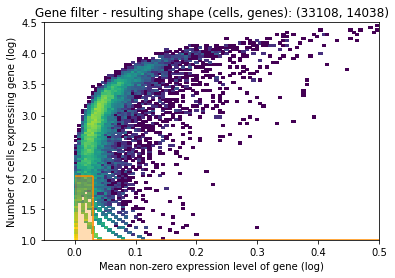

In [5]:
nonz_mean_cutoff = np.log10(1.07)
cell_count_cutoff = np.log10(10)
cell_count_cutoff2 = np.log10(slideseq.shape[0] * 0.002)

min_counts = 200 

rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(slideseq, min_counts=min_counts)
sc.pp.filter_genes(slideseq, min_cells=1)

slideseq.var['n_cells'] = np.array((slideseq.X > 0).sum(0)).flatten()
slideseq.var['nonz_mean'] = np.array(slideseq.X.sum(0)).flatten() / slideseq.var['n_cells']
    
fig, ax = plt.subplots()
ax.hist2d(np.log10(slideseq.var['nonz_mean']),
               np.log10(slideseq.var['n_cells']), bins=100,
               norm=mpl.colors.LogNorm(),
               range=[[-0.05,0.5], [1,4.5]]);
ax.axvspan(0,nonz_mean_cutoff, ymin=0.0, ymax=(cell_count_cutoff2-1)/3.5, color='darkorange', alpha=.3)
ax.axvspan(nonz_mean_cutoff,np.max(np.log10(slideseq.var['nonz_mean'])), 
               ymin=0.0, ymax=(cell_count_cutoff-1)/3.5, color='darkorange', alpha=.3)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='darkorange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='darkorange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='darkorange');
plt.xlabel("Mean non-zero expression level of gene (log)");
plt.ylabel("Number of cells expressing gene (log)");
plt.title("Gene filter - resulting shape (cells, genes): " + str(slideseq[:,(np.array(np.log10(slideseq.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(slideseq.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(slideseq.var['nonz_mean']) > nonz_mean_cutoff))].shape));
plt.show();

In [6]:
slideseq = slideseq[:,(np.array(np.log10(slideseq.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(slideseq.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(slideseq.var['nonz_mean']) > nonz_mean_cutoff))]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [7]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(slideseq.var_names, inf_aver.index)
slideseq = slideseq[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=slideseq, batch_key="batch")
scvi.data.view_anndata_setup(slideseq)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 33108 cells, 10670 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
from scvi.external.cell2location import _cell2location_v3_module
model_v2 = _cell2location_v3_module.LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:56:43<00:00,  2.83it/s, v_num=1, elbo_train=6.77e+7]  


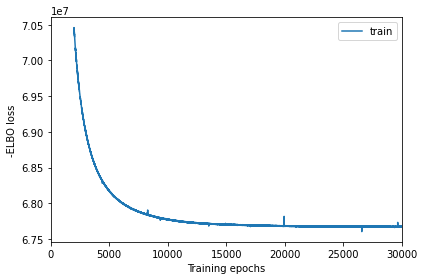

In [9]:
# create and train the model
from torch import nn
import pyro
mod = scvi.external.Cell2location(
    slideseq, cell_state_df=inf_aver, 
    #amortised=True, encoder_mode="single-multiple",
    #encoder_kwargs={'dropout_rate': 0.1, 
    #                'n_hidden': 300,
    #                'use_batch_norm': False, 'use_layer_norm': True, 
    #                'n_layers': 1, 'activation_fn': nn.ELU,
    #                #'encoder_instance': model.module.z_encoder.encoder
    #},
    # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
    N_cells_per_location=1,
    detection_alpha=20.0,
    model_class=model_v2) 
mod.train(max_epochs=30000, 
          batch_size=None, 
          train_size=1,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(2000)

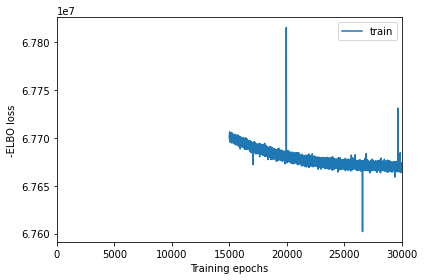

In [10]:
mod.plot_history(15000)

In [11]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    slideseq, sample_kwargs={'num_samples': 100, 'batch_size': 2502, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 99/99 [00:01<00:00, 58.05it/s]


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/signatures_v3_Adam_lr0002_alpha20_pyro_ref//sp.h5ad'

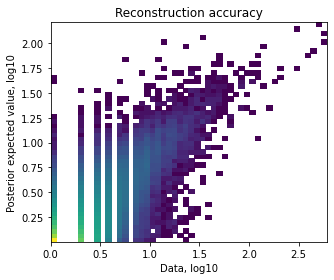

In [12]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [13]:
adata_vis.obsm['spatial'] = np.array([-adata_vis.obs['xcoord'], adata_vis.obs['ycoord']]).T

### Plot cell abundance in spatial coordinates

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


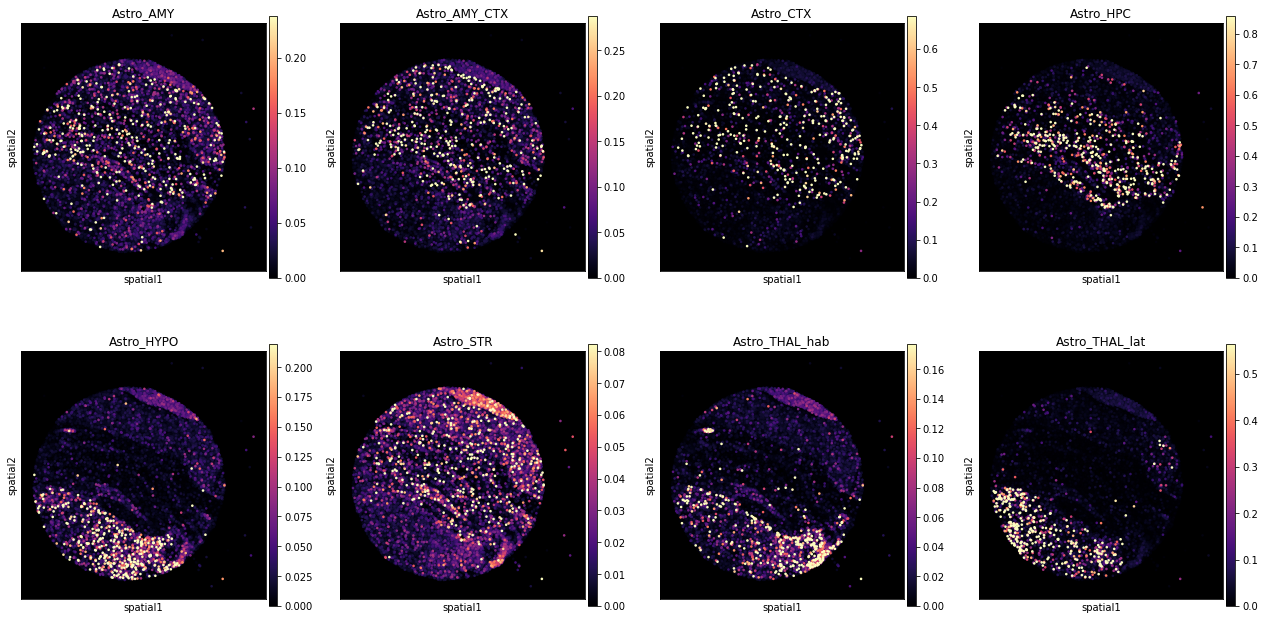

In [14]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis[adata_vis.obs['batch'] == '2'], cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'][0:8], 
                  ncols=4, size=1.3, 
                  img_key=None,
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2', spot_size=50
                 )

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


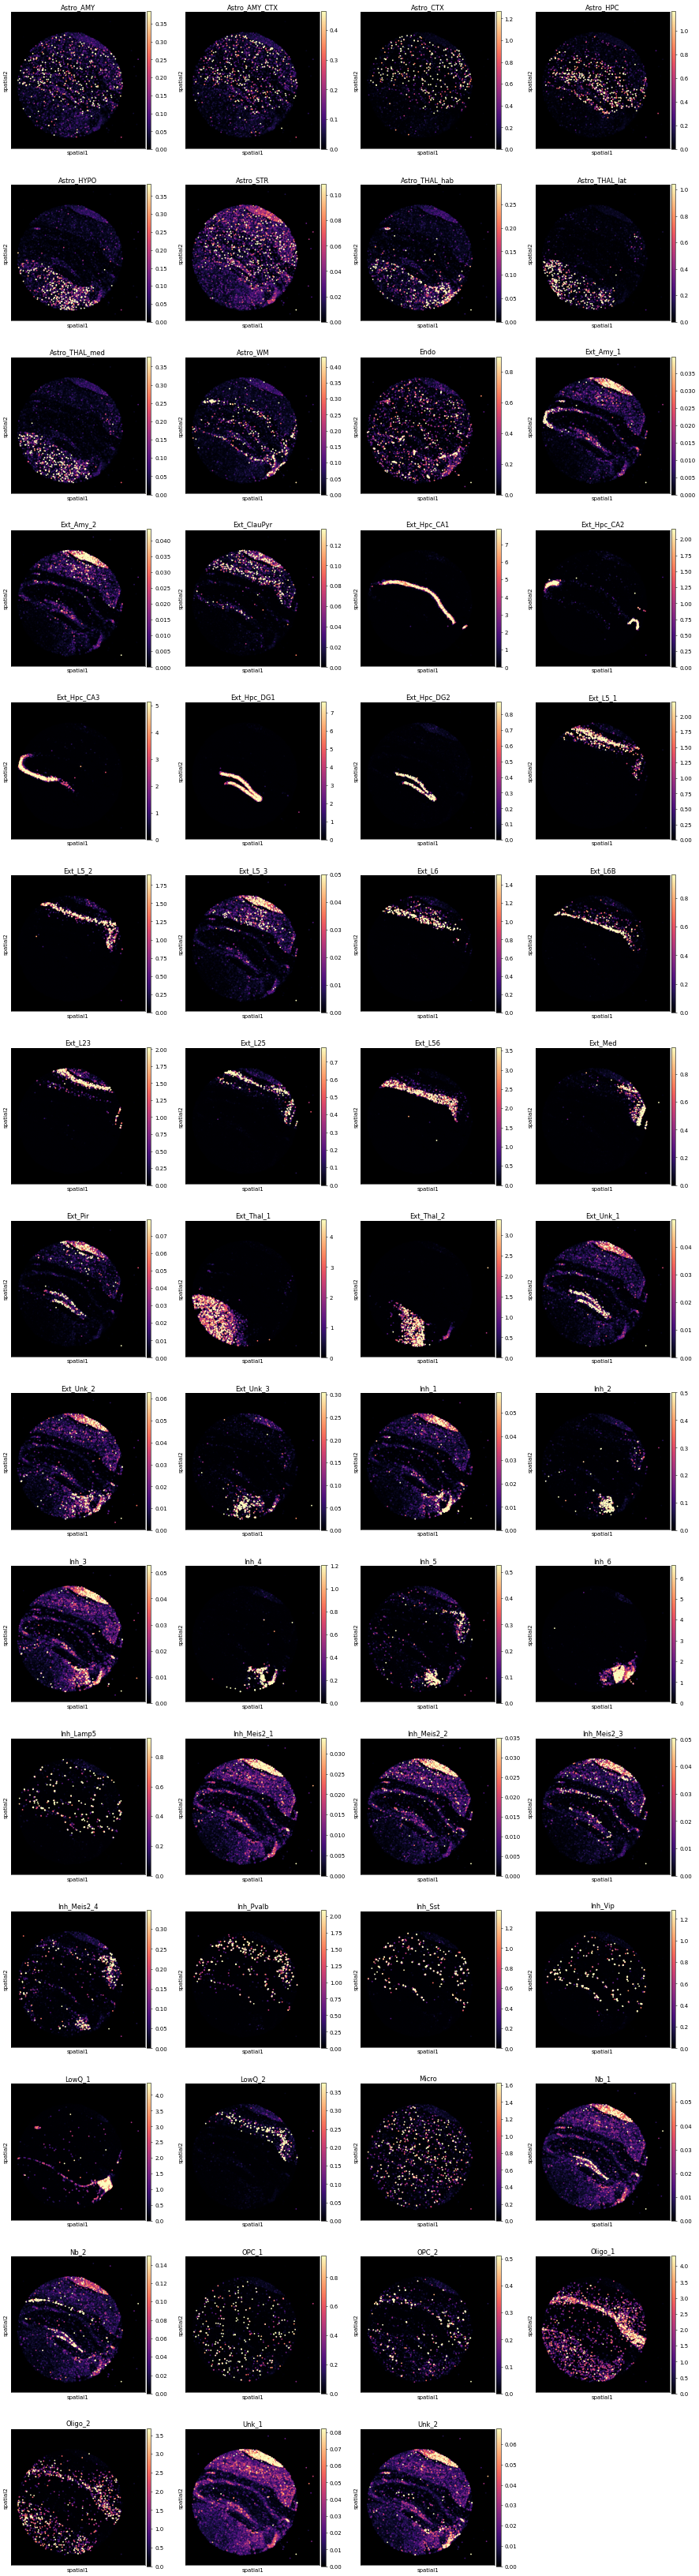

In [15]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5], 'figure.dpi':50}):
    sc.pl.spatial(adata_vis[adata_vis.obs['batch'] == '2'], cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'], 
                  ncols=4, size=1.3, 
                  img_key=None,
                  # limit color scale at 99.5% quantile of cell abundance
                  vmin=0, vmax='p99.5', spot_size=50,
                  save=f'Slide_seq_spatial_all_cell_types.pdf',
                 )

## Perform clustering of cell abudance estimates to identify tissue regions <a class="anchor" id="region_clustering"></a>

We find regions by clustering locations/spots (Leiden) based on estimated cell abundance of each cell type. Results are saved in `adata_vis.obs['region_cluster']`.

In [16]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

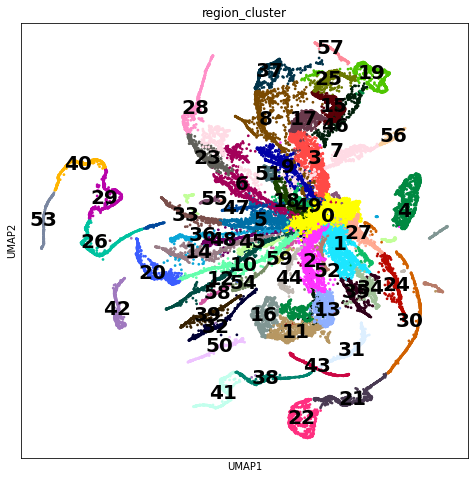

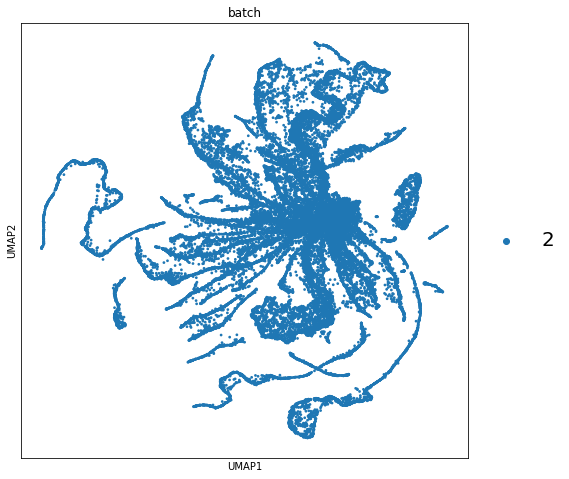

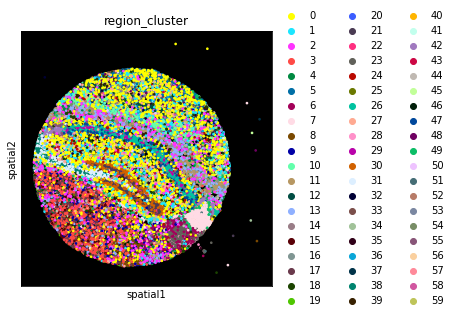

In [17]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['batch'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  img_key=None,
                  size=1.3, spot_size=50)

### Advanced use examples

Modules and their versions used for this analysis

In [18]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.